In [1]:
from time import time

import cv2
import pickle
from os import listdir
import glob
import sys
import pandas as pd
import scipy.signal as signal
from moviepy.video.io.bindings import mplfig_to_npimage
from vidgear.gears import WriteGear

sys.path.insert(1, r'C:\Users\Bio-Rehab\Documents\Sujith\openposelibs\tf-pose-estimation')

from support_mp4 import estimate_pose_frame
from tfPoseEstimator import PoseEstimator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

from support_mp4 import read_pickle_file
from support_mp4 import Params
from support_mp4 import estimate_pose
from support_mp4 import map_pos_kinematics
from support_mp4 import map_pos_frame_kinematics
from tfPoseEstimator import PoseEstimator
from support_mp4 import get_poserow
from support_mp4 import get_poserow_frame
from support_mp4 import get_trunk_angle
from support_mp4 import get_rightshoulder_angle
from support_mp4 import get_leftshoulder_angle
from support_mp4 import get_rightelbow_angles
from support_mp4 import get_leftelbow_angles
from support_mp4 import get_joint_vectors
from support_mp4 import get_vector
from support_mp4 import get_performance_row
from support_mp4 import read_colour_frames
from support_mp4 import printProgressBar
from tqdm import tqdm
import time


C:\Users\CMC\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\CMC\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\CMC\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\CMC\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dty

'\nplot initialization\n'

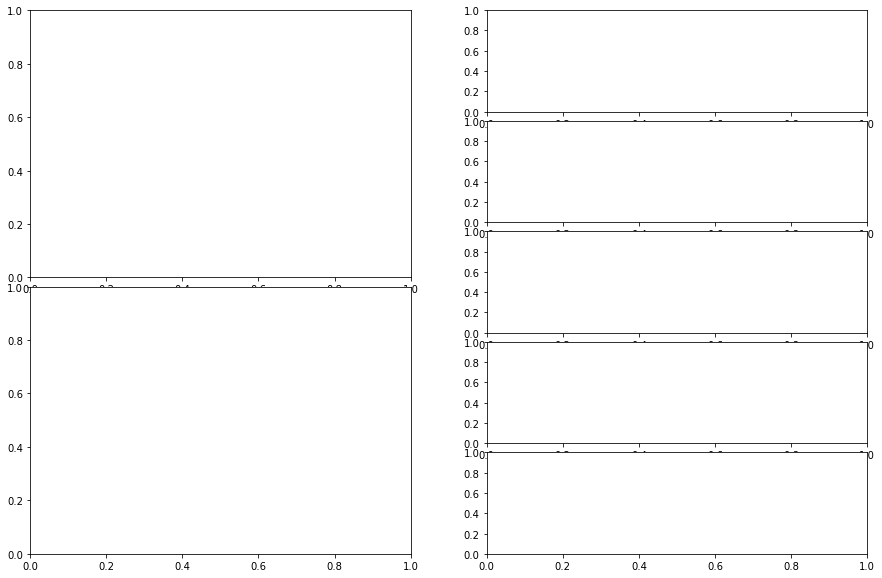

In [2]:

"""
this is plot initialization
"""

fig = plt.figure(figsize=(15, 10))
axcol = plt.subplot2grid((10, 2), (0, 0), rowspan=5, colspan=1, fig=fig)
axdep = plt.subplot2grid((10, 2), (5, 0), rowspan=5, colspan=1, fig=fig)
axtrnk = plt.subplot2grid((10, 2), (0, 1), rowspan=2, colspan=1, fig=fig)
axrshd = plt.subplot2grid((10, 2), (2, 1), rowspan=2, colspan=1, fig=fig)
axrelb = plt.subplot2grid((10, 2), (4, 1), rowspan=2, colspan=1, fig=fig)
axlshd = plt.subplot2grid((10, 2), (6, 1), rowspan=2, colspan=1, fig=fig)
axlelb = plt.subplot2grid((10, 2), (8, 1), rowspan=2, colspan=1, fig=fig)

plt.ioff()
"""
plot initialization
"""



In [ ]:
pth = r"C:\Users\CMC\Documents\openposelibs\pose\data\splitVideos\TESTXXXXBIOEM010120000000XXXXXXXXX\Session 31-05-21_14-14-19_59"

lst = listdir(pth)
vid_name = lst[0]

targetPattern = f"{pth}\\DEPTH*"
dep_lst = glob.glob(targetPattern)

targetPattern_param = f"{pth}\\PARAM*"
param_file_name = glob.glob(targetPattern_param)

param_file = open(param_file_name[0], "rb")

xyval = pickle.load(param_file)
xval = xyval[0]
yval = xyval[1]
print(xyval)

cap = cv2.VideoCapture(f"{pth}\\{vid_name}")
property_id = int(cv2.CAP_PROP_FRAME_COUNT)
frame_length = int(cv2.VideoCapture.get(cap, property_id))

dep_count = len(dep_lst) - 1
dep_num = 0

dep_file = open(f"{dep_lst[0]}", "rb")
gen_count = 1

pose_est = PoseEstimator()

col_frame = None

coldf = pd.DataFrame(columns=Params.get_pose_header_for_col())
depdf = pd.DataFrame(columns=Params.get_pose_header_for_dep())
camdf = pd.DataFrame(columns=Params.get_pose_header_for_cam())

print(f"\nEstimating pose for {frame_length} video frames")

for count in range(frame_length):
    if cap.isOpened():
        ret, col_frame = cap.read()
        if ret:
            try:
                dep_frame = pickle.load(dep_file)
            except EOFError:
                dep_file.close()
                dep_num += 1
                dep_file = open(f"{dep_lst[dep_num]}", "rb")
                dep_frame = pickle.load(dep_file)
            printProgressBar(count, frame_length)
            h = np.shape(col_frame)

            pose = estimate_pose_frame(col_frame, pose_est)

            # sys.stdout.write(f"\n{count}")

            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

            poscol, posdep, poscam = map_pos_frame_kinematics(col_frame.copy(), dep_frame.copy(), pose.copy(),
                                                              xval, yval)
            coldf = coldf.append(get_poserow_frame(poscol, Params.PoseJoints, None),
                                 ignore_index=True)
            # depth data
            depdf = depdf.append(get_poserow_frame(posdep, Params.PoseJoints, None),
                                 ignore_index=True)
            # camera data
            camdf = camdf.append(get_poserow_frame(poscam, Params.PoseJoints, None),
                                 ignore_index=True)
            # if count == 50:
            #     break
            del poscol, posdep, poscam
    gen_count += 1

print("out of loop")
colfdf = coldf.copy(deep=True)
depfdf = depdf.copy(deep=True)
camfdf = camdf.copy(deep=True)
Nmedf = 5

for _col in colfdf:
    colfdf[_col] = signal.medfilt(colfdf[_col], kernel_size=Nmedf)

for _col in depfdf:
    depfdf[_col] = signal.medfilt(depfdf[_col], kernel_size=Nmedf)

for _col in camfdf:
    camfdf[_col] = signal.medfilt(camfdf[_col], kernel_size=Nmedf)

angles_trnk = get_trunk_angle(camfdf)
anglesf_trnk = np.array([signal.medfilt(ang, kernel_size=Nmedf)
                         for ang in angles_trnk.T]).T
angles_rshd = get_rightshoulder_angle(camfdf)
anglesf_rshd = np.array([signal.medfilt(ang, kernel_size=Nmedf)
                         for ang in angles_rshd.T]).T
angles_lshd = get_leftshoulder_angle(camfdf)
anglesf_lshd = np.array([signal.medfilt(ang, kernel_size=Nmedf)
                         for ang in angles_lshd.T]).T
angles_relb = get_rightelbow_angles(camfdf)
anglesf_relb = signal.medfilt(angles_relb, kernel_size=Nmedf)
angles_lelb = get_leftelbow_angles(camfdf)
anglesf_lelb = signal.medfilt(angles_lelb, kernel_size=Nmedf)

# Organize and save angle data
# Color, depth, and camera data frames
angdf = pd.DataFrame(columns=Params.get_joint_angles_header())

# Update dataframe
angdf["TRNK_X_0"] = anglesf_trnk[:, 0]
angdf["TRNK_Y_0"] = anglesf_trnk[:, 1]
angdf["TRNK_Z_0"] = anglesf_trnk[:, 2]
angdf["RSHD_FE_0"] = anglesf_rshd[:, 0]
angdf["RSHD_AA_0"] = anglesf_rshd[:, 1]
angdf["RELB_FE_0"] = anglesf_relb
angdf["LSHD_FE_0"] = anglesf_lshd[:, 0]
angdf["LSHD_AA_0"] = anglesf_lshd[:, 1]
angdf["LELB_FE_0"] = anglesf_lelb

perf = get_performance_row(camfdf, anglesf_trnk, anglesf_rshd,
                           angles_lshd, anglesf_relb, anglesf_lelb)

print(gen_count)

cap.release()
dep_file.close()


[2021-06-04 13:02:41,660] [TfPoseEstimator] [INFO] loading graph from C:\Users\CMC\Documents\openposelibs\tf-pose-estimation\models\graph/mobilenet_thin/graph_opt.pb(default size=480x270)
2021-06-04 13:02:41,660 INFO loading graph from C:\Users\CMC\Documents\openposelibs\tf-pose-estimation\models\graph/mobilenet_thin/graph_opt.pb(default size=480x270)


[608, 254]



2021-06-04 13:02:41,661 WARNING From C:\Users\CMC\Documents\openposelibs\tf-pose-estimation\tf_pose\estimator.py:311: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



2021-06-04 13:02:41,661 WARNING From C:\Users\CMC\Documents\openposelibs\tf-pose-estimation\tf_pose\estimator.py:312: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



2021-06-04 13:02:41,676 WARNING From C:\Users\CMC\Documents\openposelibs\tf-pose-estimation\tf_pose\estimator.py:330: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



2021-06-04 13:02:41,806 WARNING From C:\Users\CMC\Documents\openposelibs\tf-pose-estimation\tf_pose\estimator.py:332: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



TfPoseEstimator/MobilenetV1/Conv2d_0/weights
TfPoseEstimator/image
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_0/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_0/Relu
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Relu
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D_bn_offset
TfPoseEstimator/M

TfPoseEstimator/Openpose/MConv_Stage3_L1_2_pointwise/BatchNorm/FusedBatchNorm
TfPoseEstimator/Openpose/MConv_Stage3_L1_2_pointwise/Relu
TfPoseEstimator/Openpose/MConv_Stage3_L1_3_depthwise/depthwise_weights
TfPoseEstimator/Openpose/MConv_Stage3_L1_3_pointwise/weights
TfPoseEstimator/Openpose/MConv_Stage3_L1_3_depthwise/depthwise
TfPoseEstimator/Openpose/MConv_Stage3_L1_3_pointwise/Conv2D
TfPoseEstimator/Openpose/MConv_Stage3_L1_3_pointwise/Conv2D_bn_offset
TfPoseEstimator/Openpose/MConv_Stage3_L1_3_pointwise/BatchNorm/FusedBatchNorm
TfPoseEstimator/Openpose/MConv_Stage3_L1_3_pointwise/Relu
TfPoseEstimator/Openpose/MConv_Stage3_L1_4_depthwise/depthwise_weights
TfPoseEstimator/Openpose/MConv_Stage3_L1_4_pointwise/weights
TfPoseEstimator/Openpose/MConv_Stage3_L1_4_depthwise/depthwise
TfPoseEstimator/Openpose/MConv_Stage3_L1_4_pointwise/Conv2D
TfPoseEstimator/Openpose/MConv_Stage3_L1_4_pointwise/Conv2D_bn_offset
TfPoseEstimator/Openpose/MConv_Stage3_L1_4_pointwise/BatchNorm/FusedBatchNorm


2021-06-04 13:02:41,873 WARNING From C:\Users\CMC\Documents\openposelibs\tf-pose-estimation\tf_pose\estimator.py:341: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2021-06-04 13:02:41,875 WARNING From C:\Users\CMC\Documents\openposelibs\tf-pose-estimation\tf_pose\estimator.py:342: The name tf.image.resize_area is deprecated. Please use tf.compat.v1.image.resize_area instead.



2021-06-04 13:02:41,882 WARNING From C:\Users\CMC\Documents\openposelibs\tf-pose-estimation\tf_pose\tensblur\smoother.py:96: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2021-06-04 13:02:41,890 WARNING From C:\Users\CMC\Documents\openposelibs\tf-pose-estimation\tf_pose\estimator.py:354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Estimating pose for 4060 video frames


In [ ]:

"""
Writing video from analysis
"""

cap1 = cv2.VideoCapture(f"{pth}\\{vid_name}")
property_id = int(cv2.CAP_PROP_FRAME_COUNT)
frame_length = int(cv2.VideoCapture.get(cap1, property_id))

dep_count = len(dep_lst) - 1
dep_num = 0

dep_file = open(f"{dep_lst[0]}", "rb")
gen_count = 1

fig = plt.figure(figsize=(15, 10))
axcol = plt.subplot2grid((10, 2), (0, 0), rowspan=5, colspan=1, fig=fig)
axdep = plt.subplot2grid((10, 2), (5, 0), rowspan=5, colspan=1, fig=fig)
axtrnk = plt.subplot2grid((10, 2), (0, 1), rowspan=2, colspan=1, fig=fig)
axrshd = plt.subplot2grid((10, 2), (2, 1), rowspan=2, colspan=1, fig=fig)
axrelb = plt.subplot2grid((10, 2), (4, 1), rowspan=2, colspan=1, fig=fig)
axlshd = plt.subplot2grid((10, 2), (6, 1), rowspan=2, colspan=1, fig=fig)
axlelb = plt.subplot2grid((10, 2), (8, 1), rowspan=2, colspan=1, fig=fig)
plt.ioff()


def make_video_frame(col, dep):
    axcol.clear()
    axdep.clear()
    axtrnk.clear()
    axrshd.clear()
    axrelb.clear()
    axlshd.clear()
    axlelb.clear()

    # Plot the color and depth images and the pose points.
    # Show color and depth images
    axcol.imshow(col[:, :, ::-1])
    axdep.imshow(dep)
    axcol.set_xticks([])
    axcol.set_yticks([])
    axdep.set_xticks([])
    axdep.set_yticks([])
    inx = frame_length - 1
    T = 15
    dT = 0.1
    N = frame_length
    # N = sz + 1
    time = np.arange(0, dT * N, dT)

    for _j in Params.PoseJoints + Params.ExtraPoseJoints:
        # print("\n", _j, inx)
        # print("this is data", self.alldata["colfdf"].loc[inx, f"{_j}_x_0"])
        axcol.plot((colfdf.loc[inx, f"{_j}_x_0"] - xval) / 2,
                   (colfdf.loc[inx, f"{_j}_y_0"] - yval) / 2, 'o')
        axdep.plot(depfdf.loc[inx, f"{_j}_x_0"],
                   depfdf.loc[inx, f"{_j}_y_0"], 'o')

    # Plot angles.
    # Trunk angle
    axtrnk.plot(time, angdf["TRNK_X_0"], label="x angle")
    axtrnk.plot(time, angdf["TRNK_Z_0"], label="z angle")
    axtrnk.grid(color='tab:gray', alpha=0.4, linestyle='-', linewidth=0.5, axis='both')
    axtrnk.set_xlim([-T + dT * inx, dT * inx])
    axtrnk.set_title("Trunk angles")
    axtrnk.legend(loc=2, frameon=False)

    # Right shoulder angle
    axrshd.plot(time, angdf["RSHD_FE_0"], label="FE")
    axrshd.plot(time, angdf["RSHD_AA_0"], label="AA")
    axrshd.grid(color='tab:gray', alpha=0.4, linestyle='-', linewidth=0.5, axis='both')
    axrshd.set_xlim([-T + dT * inx, dT * inx])
    axrshd.set_title("Right shoulder angles")
    axrshd.legend(loc=2, frameon=False)

    # Right elbow angle
    axrelb.plot(time, angdf["RELB_FE_0"])
    axrelb.grid(color='tab:gray', alpha=0.4, linestyle='-', linewidth=0.5, axis='both')
    axrelb.set_xlim([-T + dT * inx, dT * inx])
    axrelb.set_title("Right elbow angle")

    # Left shoulder angle
    axlshd.plot(time, angdf["LSHD_FE_0"], label="FE")
    axlshd.plot(time, angdf["LSHD_AA_0"], label="AA")
    axlshd.grid(color='tab:gray', alpha=0.4, linestyle='-', linewidth=0.5, axis='both')
    axlshd.set_xlim([-T + dT * inx, dT * inx])
    axlshd.set_title("Left shoulder angles")
    axlshd.legend(loc=2, frameon=False)

    # Left elbow angle
    axlelb.plot(time, angdf["LELB_FE_0"])
    axlelb.grid(color='tab:gray', alpha=0.4, linestyle='-', linewidth=0.5, axis='both')
    axlelb.set_xlim([-T + dT * inx, dT * inx])
    axlelb.set_title("Left elbow angle")

    return mplfig_to_npimage(fig)


writer = WriteGear(output_filename="Output.mp4")
# result = cv2.VideoWriter('filename.avi', cv2.VideoWriter_fourcc(*'MJPG'), 10, (432, 368))
for count in range(frame_length):
    if cap1.isOpened():
        ret, col_frame = cap1.read()
        if ret:
            try:
                dep_frame = pickle.load(dep_file)
            except EOFError:
                dep_file.close()
                dep_num += 1
                dep_file = open(f"{dep_lst[dep_num]}", "rb")
                dep_frame = pickle.load(dep_file)

            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

            printProgressBar(count, frame_length)
            # if count == 50:
            #     break

            img = make_video_frame(col_frame, dep_frame)
            cv2.imshow("image", img)
            time.sleep(0.1)
            # result.write(img)
            # writer.write(img)

    gen_count += 1
# result.release()
writer.close()
cap1.release()